In [1]:
from load_data import load_data
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
from vispy.color import ColorArray
from PIL import Image

In [2]:
%config Completer.use_jedi = False

In [3]:
def print_image(image_data):
    plt.imshow(image_data, interpolation='nearest')
    plt.show()

In [4]:
#data = load_data(os.getcwd()+"/data/demo.p")
data = load_data(os.getcwd()+"/data/demo.p")

# Task 1 Bird's Eye of View

In [102]:
min_height = np.min(data['velodyne'][:,-2])
max_height = np.max(data['velodyne'][:,-2])

In [160]:
im = birds_eye_point_cloud(data['velodyne'],min_height=min_height,max_height=max_height)

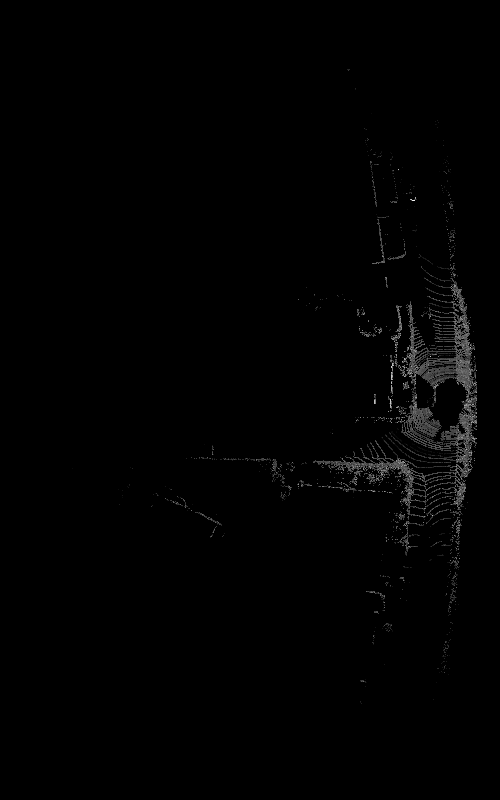

In [161]:
im

In [91]:
range_of_vec(data['velodyne'][:,0])

(-80.51211, 78.89815)

In [159]:
from PIL import Image
import numpy as np

# ==============================================================================
#                                                                   SCALE_TO_255
# ==============================================================================
def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)

def range_of_vec(data):
    return (np.min(data),np.max(data))

# ==============================================================================
#                                                          BIRDS_EYE_POINT_CLOUD
# ==============================================================================
def birds_eye_point_cloud(points,
                          side_range=(10,110),
                          fwd_range=(-80,80),
                          res=0.2,
                          min_height = -2.73,
                          max_height = 5,
                          saveto='text_image.jpg'):
    """ Creates an 2D birds eye view representation of the point cloud data.
        You can optionally save the image to specified filename.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        res:        (float) desired resolution in metres to use
                    Each output pixel will represent an square region res x res
                    in size.
        min_height:  (float)(default=-2.73)
                    Used to truncate height values to this minumum height
                    relative to the sensor (in metres).
                    The default is set to -2.73, which is 1 metre below a flat
                    road surface given the configuration in the kitti dataset.
        max_height: (float)(default=1.27)
                    Used to truncate height values to this maximum height
                    relative to the sensor (in metres).
                    The default is set to 1.27, which is 3m above a flat road
                    surface given the configuration in the kitti dataset.
        saveto:     (str or None)(default=None)
                    Filename to save the image as.
                    If None, then it just displays the image.
    """
    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    r_lidar = points[:, 3]  # Reflectance
    
    #side_range = range_of_vec(points[:,1])
    #fwd_range = range_of_vec(points[:,0])
    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_lidar/res).astype(np.int32) # x axis is -y in LIDAR
    y_img = (x_lidar/res).astype(np.int32)  # y axis is -x in LIDAR
                                                     # will be inverted later

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor used to prevent issues with -ve vals rounding upwards
    x_img -= int(np.floor(side_range[0]/res))
    y_img -= int(np.floor(fwd_range[0]/res))

    # CLIP HEIGHT VALUES - to between min and max heights
    #pixel_values = np.clip(a = z_lidar[indices],
    #                       a_min=min_height,
    #                       a_max=max_height)

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    #pixel_values  = scale_to_255(z_lidar, min=min_height, max=max_height)
    pixel_values = scale_to_255(r_lidar,min=0.0,max=1.0)
    
    # FILL PIXEL VALUES IN IMAGE ARRAY
    x_max = int((side_range[1] - side_range[0])/res)
    y_max = int((fwd_range[1] - fwd_range[0])/res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)
    im[-y_img, x_img] = pixel_values # -y because images start from top left

    # Convert from numpy array to a PIL image
    im = Image.fromarray(im)
    
    # SAVE THE IMAGE
    if saveto is not None:
        im.save(saveto)
    else:
        im.show()
    return im

# Task 2

## 2.1

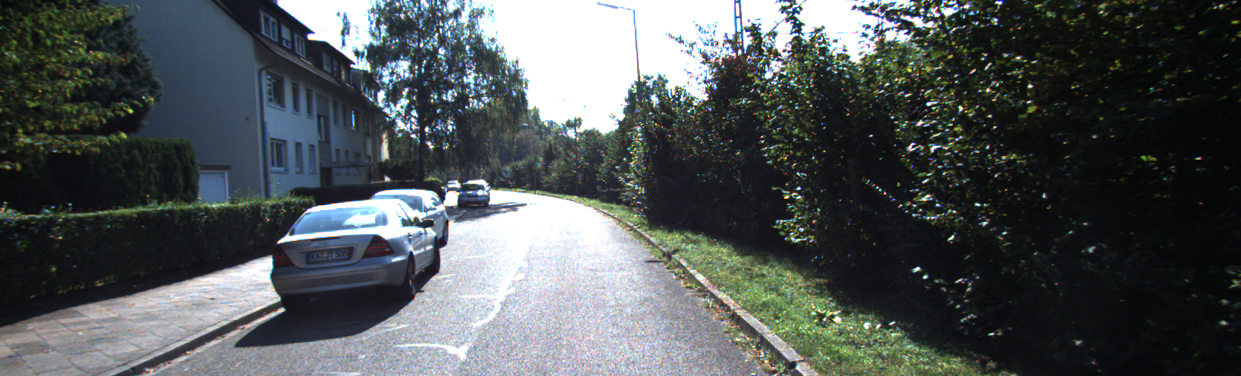

In [176]:
data = load_data('data/demo.p') # Change to data.p for your final submission 

img = data["image_2"]
R1 = data["T_cam2_velo"]
R2 = data["P_rect_20"]
im = Image.fromarray(np.uint8(img), "RGB")
display(im)

In [199]:
data = load_data('data/demo.p') # Change to data.p for your final submission 
points = data['velodyne'][:,:-1]
# Forward is kept
ind = points[:,0]>=0
points = points[ind]
label_clip = data['sem_label'][ind]

# Homonegenous
P = np.concatenate([points,np.ones([points.shape[0],1])],axis=1)
# Multiply different parameter matrices to project 3D points on the 2D camera 2 image
P_2 = np.empty(points.shape)
R2 = data['P_rect_20'] #intrinsic
R1 = data['T_cam0_velo'] #extrinsic
for ind,point in enumerate(P):
    # Projection
    P_2[ind,:] = np.dot(np.dot(R2,R1),point)
    # Normalization
    P_2[ind,:] = P_2[ind,:]/P_2[ind,-1]

P_2 = P_2.astype(int)
# Filter out ones not inside the perspective
img = data['image_2']
ind_x = np.logical_and(P_2[:,1] < img.shape[0], P_2[:,1] >= 0)
ind_y = np.logical_and(P_2[:,0] < img.shape[1], P_2[:,0] >= 0)
ind_z = P_2[:,-1]>=0
ind = np.logical_and(ind_x,ind_y)
ind = np.logical_and(ind,ind_z)

#Convert the index to integer
P_clip = P_2[ind].astype(int)
label_clip = label_clip[ind]

# Color for each pixel position
color = np.empty([P_clip.shape[0],3])
for ind,label in enumerate(label_clip):
    color[ind,:] = data['color_map'][label[0]]
    color[ind,:] = [color[ind,-1],color[ind,1],color[ind,0]]
#color = ColorArray(color,clip=True)

In [200]:
for i,point in enumerate(P_clip):
    img[point[1],point[0],:] = color[i,:]

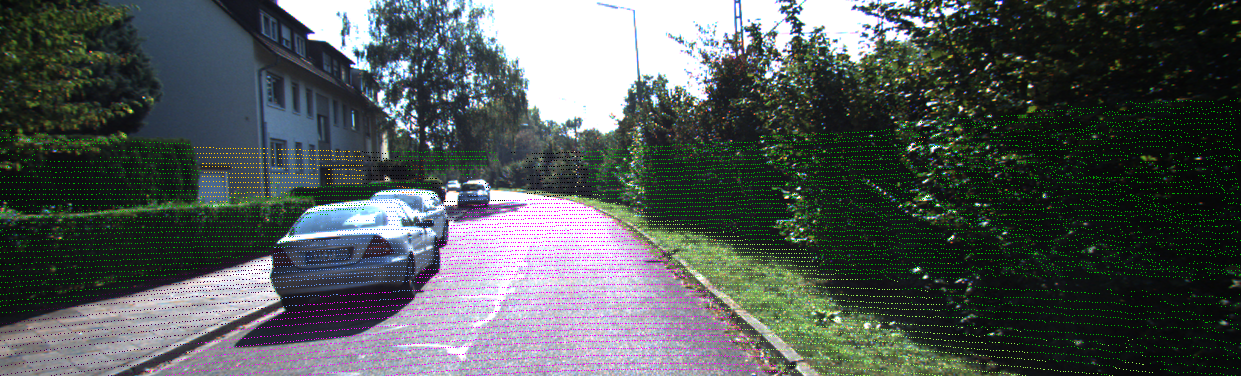

In [201]:
im = Image.fromarray(np.uint8(img), "RGB")
display(im)

## 2.2 BBOX

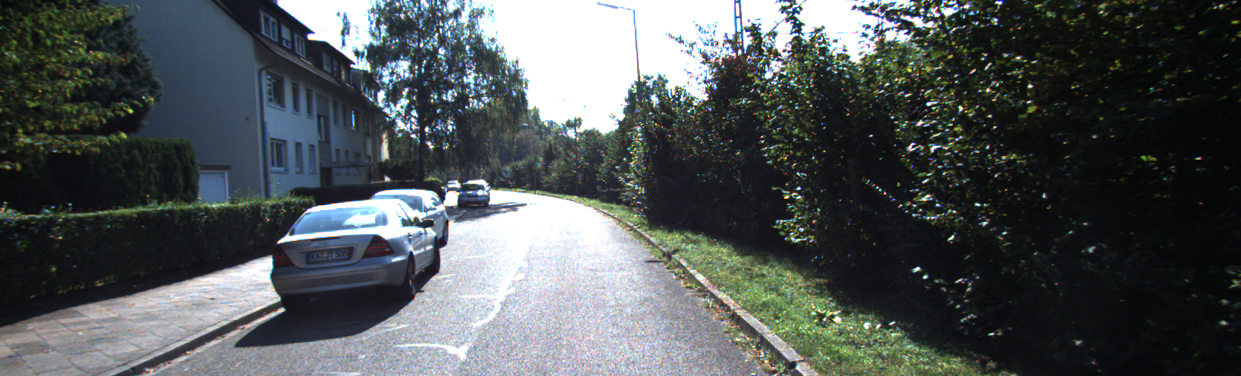

In [260]:
data = load_data('data/demo.p') # Change to data.p for your final submission 

img = data["image_2"]
R1 = data["T_cam2_velo"]
R2 = data["P_rect_20"]
im = Image.fromarray(np.uint8(img), "RGB")
display(im)

In [271]:
objects = data['objects']
corners = np.empty([len(objects),8,3])
i = 0
for individual in objects:
    # Height, Width, Length 
    dimension = np.array(individual[8:11])
    # Right, Down, Front (X,Y,Z)
    location = np.array(individual[11:14])
    rotation_y = individual[14]
    corner = np.zeros([8,3])
    corner[0,:] = location + np.array([dimension[2]/2,-dimension[0],dimension[1]/2])
    corner[1,:] = corner[0,:] + np.array([-dimension[-1],0,0])
    corner[2,:] = corner[1,:] + np.array([0,0,-dimension[1]])
    corner[3,:] = corner[2,:] + np.array([dimension[2],0,0])
    corner[4,:] = corner[0,:] + np.array([0,dimension[0],0])
    corner[5,:] = corner[4,:] + np.array([0,0,-dimension[1]])
    corner[6,:] = corner[5,:] + np.array([0,0,-dimension[1]])
    corner[7,:] = corner[6,:] + np.array([dimension[2],0,0])
    # Rotate along the y-axis
    R = np.array([[np.cos(rotation_y),0,np.sin(rotation_y)],[0,1,0],[-np.sin(rotation_y),0,np.cos(rotation_y)]])
    ind = 0
    for point in corner:
        corner[ind,:] = np.dot(R,point)
        ind += 1
    corners[i,:,:] = corner
    i += 1


In [272]:
for bbox in corners:
    for ind,pt in enumerate(bbox):
        pos = np.dot(np.dot(R2,R1),np.concatenate((pt,[1])))
        pos /= pos[-1]
        pos = pos.astype(int)
        bbox[ind]=pos
    # (0,1),(0,3),(0,4),(1,2),(1,5),(2,3),(2,6),(3,7),(4,5),(4,7),(5,6),(6,7)
    pts = line_between_pts(bbox[0],bbox[1])
    pts = np.concatenate([pts,line_between_pts(bbox[0],bbox[3])])
    pts = np.concatenate([pts,line_between_pts(bbox[0],bbox[4])])
    pts = np.concatenate([pts,line_between_pts(bbox[1],bbox[2])])
    pts = np.concatenate([pts,line_between_pts(bbox[1],bbox[5])])
    pts = np.concatenate([pts,line_between_pts(bbox[2],bbox[3])])
    pts = np.concatenate([pts,line_between_pts(bbox[2],bbox[6])])
    pts = np.concatenate([pts,line_between_pts(bbox[3],bbox[7])])
    pts = np.concatenate([pts,line_between_pts(bbox[4],bbox[5])])
    pts = np.concatenate([pts,line_between_pts(bbox[4],bbox[7])])    
    pts = np.concatenate([pts,line_between_pts(bbox[5],bbox[6])])
    pts = np.concatenate([pts,line_between_pts(bbox[6],bbox[7])])
    #pts[:,0] = np.clip(pts[:,0],0,img.shape[1])
    #pts[:,1] = np.clip(pts[:,1],0,img.shape[0])
    for corner in pts:
        img[pos[1],pos[0],:] =[0,128,0] 

In [262]:
pts = line_between_pts(bbox[0],bbox[1])

In [264]:
pts[:,0] = np.clip(pts[:,0],0,img.shape[1])
pts[:,1] = np.clip(pts[:,1],0,img.shape[0])

In [277]:
corners

array([[[ 607.,   25.,    1.],
        [ 605., -239.,    1.],
        [ 605., -296.,    1.],
        [ 607.,   12.,    1.],
        [ 694.,   25.,    1.],
        [ 707.,   11.,    1.],
        [ 726.,   -8.,    1.],
        [ 723.,  328.,    1.]],

       [[ 609.,   34.,    1.],
        [ 608., -126.,    1.],
        [ 608., -155.,    1.],
        [ 609.,   21.,    1.],
        [ 548.,   34.,    1.],
        [ 542.,   21.,    1.],
        [ 535.,    5.,    1.],
        [ 537.,  199.,    1.]],

       [[ 613., -102.,    1.],
        [ 612., -185.,    1.],
        [ 613., -194.,    1.],
        [ 613., -107.,    1.],
        [ 586., -102.,    1.],
        [ 585., -107.,    1.],
        [ 584., -112.,    1.],
        [ 586.,  -26.,    1.]]])

In [275]:
pts

array([[ 613.   , -102.   ,    1.   ],
       [ 612.999, -102.083,    1.   ],
       [ 612.998, -102.166,    1.   ],
       ...,
       [ 585.996,  -26.172,    1.   ],
       [ 585.998,  -26.086,    1.   ],
       [ 586.   ,  -26.   ,    1.   ]])

In [274]:
np.sum(pts[:,1])

-1403902.5

In [273]:
img.shape

(376, 1241, 3)

In [261]:
# Draw line between two points
def line_between_pts(pt1,pt2):
    pts = []
    for i in range(1001):
        pts.append(pt1 + (pt2-pt1)/1000 * i)
    pts = np.array(pts)
    return pts

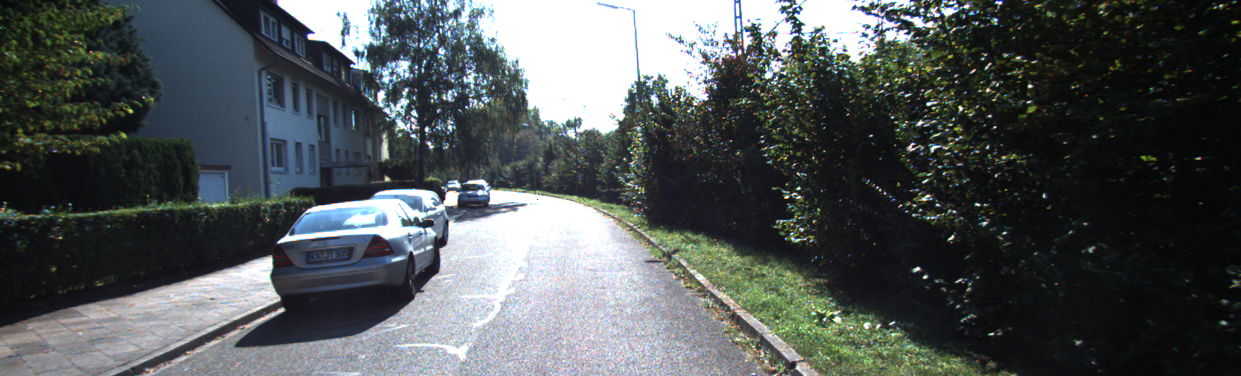

In [259]:
im = Image.fromarray(np.uint8(img), "RGB")
display(im)


In [341]:
P

array([[33.36267853,  0.05796321,  1.33702469,  1.        ],
       [34.26109695,  0.1678935 ,  1.36807191,  1.        ],
       [47.17047501,  0.38875455,  1.80417264,  1.        ],
       ...,
       [ 3.85864401, -1.43420494, -1.77484024,  1.        ],
       [ 3.86732841, -1.43020701, -1.777843  ,  1.        ],
       [ 3.8917594 , -1.42620933, -1.78784895,  1.        ]])

## 2.3

In [91]:
import vispy
from vispy.scene import visuals, SceneCanvas
import numpy as np
import os
from load_data import load_data

class Visualizer():
    def __init__(self):
        self.canvas = SceneCanvas(keys='interactive', show=True)
        self.grid = self.canvas.central_widget.add_grid()
        self.view = vispy.scene.widgets.ViewBox(border_color='white',
                        parent=self.canvas.scene)
        self.grid.add_widget(self.view, 0, 0)

        # Point Cloud Visualizer
        self.sem_vis = visuals.Markers()
        self.view.camera = vispy.scene.cameras.TurntableCamera(up='z', azimuth=90)
        self.view.add(self.sem_vis)
        visuals.XYZAxis(parent=self.view.scene)
        
        # Object Detection Visualizer
        self.obj_vis = visuals.Line()
        self.view.add(self.obj_vis)
        self.connect = np.asarray([[0,1],[0,3],[0,4],
                                   [2,1],[2,3],[2,6],
                                   [5,1],[5,4],[5,6],
                                   [7,3],[7,4],[7,6]])

    def update(self, points):
        '''
        :param points: point cloud data
                        shape (N, 3)          
        Task 2: Change this function such that each point
        is colored depending on its semantic label
        '''
        # Multiply different parameter matrices to project 3D points on the 2D camera 2 image

        data = load_data('data/demo.p') # Change to data.p for your final submission 
        P = np.concatenate([points,np.ones([points.shape[0],1])],axis=1)
        # Multiply different parameter matrices to project 3D points on the 2D camera 2 image
        P_2 = np.empty(points.shape)
        R2 = data['P_rect_20'] #intrinsic
        R1 = data['T_cam0_velo'] #extrinsic
        for ind,point in enumerate(P):
            # Projection
            P_2[ind,:] = np.dot(np.dot(R2,R1),point)
            # Normalization
            P_2[ind,:] = P_2[ind,:]/P_2[ind,-1]

        # Filter out ones not inside the perspective
        img = data['image_2']
        ind_x = np.logical_and(P_2[:,1] <= img.shape[0], P_2[:,1] >= 0)
        ind_y = np.logical_and(P_2[:,0] <= img.shape[1], P_2[:,0] >= 0)
        ind = np.logical_and(ind_x,ind_y)

        # Convert the index to integer
        P_clip = P_2[ind].astype(int)
        label_clip = data['sem_label'][ind]

        # Color for each pixel position
        color = np.empty([P_clip.shape[0],3])
        for ind,label in enumerate(label_clip):
            color[ind,:] = data['color_map'][label[0]]
        color = ColorArray(color,clip=True)
        self.sem_vis.set_data(P_clip,edge_color=color, size=3)
                
    
    def update_boxes(self, corners):
        '''
        :param corners: corners of the bounding boxes
                        shape (N, 8, 3) for N boxes
        (8, 3) array of vertices for the 3D box in
        following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
        If you plan to use a different order, you can
        change self.connect accordinly.
        '''
        for i in range(corners.shape[0]):
            connect = np.concatenate((connect, self.connect+8*i), axis=0) \
                      if i>0 else self.connect
        self.obj_vis.set_data(corners.reshape(-1,3),
                              connect=connect,
                              width=2,
                              color=[0,1,0,1])

In [ ]:
    data = load_data('data/demo.p') # Change to data.p for your final submission 
    visualizer = Visualizer()
    visualizer.update(data['velodyne'][:,:3])
    '''
    Task 2: Compute all bounding box corners from given
    annotations. You can visualize the bounding boxes using
    visualizer.update_boxes(corners)
    '''
    vispy.app.run()
